In [1]:
#Aim of this notebook is to gather metrics related to productivity.
#In particular, will try to structre around a 'cycle' of low/high productivity.
#Hypothesised cycle: productivity -> pay -> living standards -> attainment/skills -> productivity

In [2]:
#LUDA data prod metrics that may be worth including
#Productivity: GVA, high growth business, innovation
#Pay: Weekly pay, domestic income, NEET
#Living standards: Healthy LE, physical activity, green space, employment rate, life satisfaction
#Attaiment & skills: GSCEs, 5yr old standards, apprenticeships

In [3]:
#Get data -- first from published subnat explorer.
from google.cloud import bigquery
import pandas as pd
client = bigquery.Client(location=" europe-west2")

query = """
    SELECT AREACD, Indicator, Value 
    FROM `ons-luda-data-prod.ingest_luda.20220201_subnational_indicators_explorer_p` 
    
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="europe-west2",
)  # API request - starts the query

subnat_explorer_metrics = query_job.to_dataframe()

In [4]:
#Helpful functions for moving metrics about.
def cut_single_metric(name):
    return subnat_explorer_metrics[subnat_explorer_metrics['Indicator']==name]

def query_to_dataframe(query):
    client = bigquery.Client(location=" europe-west2")
    query_job = client.query(query, location="europe-west2",)  
    return(query_job.to_dataframe())

def get_most_recent(data, year_syntax='YEAR'):
    most_recent_year = data[data[year_syntax] == data[year_syntax].max()]
    return(most_recent_year)

In [5]:
#Productivity
gva = cut_single_metric("Gross Value Added per hour worked")
query = """SELECT GEOGRAPHY, YEAR, HIGH_GROWTH_BUSINESSES as Value FROM `ons-luda-data-prod.ingest_luda.02_biz_high_growth`"""
high_growth = query_to_dataframe(query)
high_growth = get_most_recent(high_growth)
high_growth['Indicator']='High growth businesses'


In [6]:
#Pay
weekly_pay = cut_single_metric("Gross median weekly pay")

query="""SELECT LAD_CODE, YEAR, GDI_PER_HEAD as Value FROM `ons-luda-data-prod.ingest_luda.48_gdi_per_capita`"""
gdi = get_most_recent(query_to_dataframe(query))
gdi['Indicator'] = 'GDI per head'

query="""SELECT ONS_GEOGRAPHY_CODE_9_DIGIT, YEAR, PROPORTION_NEET_OR_NOT_KNOWN as Value FROM `ons-luda-data-prod.ingest_luda.46_neet`"""
neet = get_most_recent(query_to_dataframe(query))
#For some reason, looks like this table has duplicated rows.
neet = neet.drop_duplicates()
neet['Indicator'] = 'Proportion NEET'


In [7]:
#Living standards

male_hle = cut_single_metric("Male healthy life expectancy")
female_hle = cut_single_metric("Female healthy life expectancy")
satisfaction = cut_single_metric("Average life satisfaction rating")

#Think we've questioned this metric for rural areas...
query="""SELECT LAD_CODE, AVERAGE_DISTANCE_TO_NEAREST_PARK_OR_PUBLIC_GARDEN_OR_PLAYING_FIELD_M as Value FROM `ons-luda-data-prod.ingest_luda.49-green_space`"""
green_space = query_to_dataframe(query)
green_space['Indicator'] = 'Avergae distance to park or public garden or playing field'

query="""SELECT CODE, YEAR, ACTIVITY, RATE_PERCENTAGE as Value FROM `ons-luda-data-prod.ingest_luda.44_physical_activity`"""
activity = get_most_recent(query_to_dataframe(query))
#Take inactive metric as proportion inactive
inactive = activity[activity["ACTIVITY"]=="Inactive"]
inactive.pop("ACTIVITY")
inactive['Indicator'] = 'Proportion inactive'

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
#Attainment/skills
gcses = cut_single_metric("Young people achieving GCSEs (and equivalent qualifications) in English and Maths by age 19")

maths_5 = cut_single_metric("5 year olds achieving 'expected level' on maths early learning goals")
lit_5 = cut_single_metric("5 year olds achieving 'expected level' on literacy early learning goals")
comm_5 = cut_single_metric("5 year olds achieving 'expected level' on communication early learning goals")

employ_rate = cut_single_metric("Employment rate for 16 to 64 year olds")

app_start = cut_single_metric("Number of completions on apprenticeships") #Note: need a rate?
app_completion = cut_single_metric("Number of starts on apprenticeships")

In [9]:
#What we want to do next in check coverage and coherence.
#Think HLE is at Upper-tier local authority in England.

#def get_number_area(dataset, )
def get_code_column(dataset, flag='E0'):
    """Usage: The flag is a substring that we want to identify geography codes. 
    Default is E0, which is the prefix of areas in England, 
    but can be specified otherwise if data isn't at that level."""
    #Note use of groupby here as there was a deprecation warning for all(level=1), suggesting groupby(level=1).all() is safer.
    #But beware that default behaviour of groupby is to sort alphabetically, which we very much don't want!
    col = dataset.columns[dataset.stack().str.contains(flag).groupby(level=1, sort=False).any()]
    if len(col)==0:
        print("ERROR: No columns that look like the contain geography codes found. Checking if the flag entered matches the expected pattern")
    return(col)

def number_areas(dataset, flag='E0'):
    area_col = get_code_column(dataset, flag)
    if len(area_col)==0:
        return(0)
    areas = dataset[area_col].drop_duplicates()
    return(len(areas))
        

In [10]:
metrics = ["gva", "high_growth", "weekly_pay", "gdi", "neet", "employ_rate", 
           "male_hle", "female_hle", "gcses", "maths_5", "lit_5", "comm_5", "app_start", "app_completion",
          "satisfaction", "green_space", "inactive"]
for metric in metrics:
    print(metric, number_areas(eval(metric)))


gva 363
high_growth 395
weekly_pay 374
gdi 382
neet 164
employ_rate 374
male_hle 216
female_hle 216
gcses 317
maths_5 151
lit_5 151
comm_5 151
app_start 309
app_completion 309
satisfaction 382
green_space 371
inactive 339


In [11]:
#Tells us where we have UTLA (upper tier LA) data, as well as hinting on coverage.


In [12]:
#Get consistent coverage.
#What seems like it should work be England, lower tier LA.
upp_low_tier = pd.read_csv("lookup/Lower_Tier_Local_Authority_to_Upper_Tier_Local_Authority__April_2019__Lookup_in_England_and_Wales.csv")
upp_low_tier = upp_low_tier[["LTLA19CD", "UTLA19CD"]]

In [13]:
#Simplest way to model this would be when we have UT data, model LT data as all equal to UT.
#This seems easy to justify as best guess.
#For similarity work, this effectively weights UT only data by number of LT areas it corresponds to.
#It also produces identical lower tier LAs as an artefact?
all_UT = upp_low_tier["UTLA19CD"].drop_duplicates()

def UT_metric_to_LT(metric):
    lower_metrics=[]
    area_col = get_code_column(metric)
    print(area_col)
    for row in range(len(metric)):
        #Test to see if this a upper tier LA. If it is, replace it with lower tier.
        if metric.iloc[row].loc[area_col][0] in list(all_UT):
            lower_metric = metric.reset_index().truncate(row,row).merge(upp_low_tier, left_on=area_col[0], right_on="UTLA19CD", how="left")
            lower_metric = lower_metric.drop(columns=[area_col[0], 'UTLA19CD'])
            col = lower_metric.pop('LTLA19CD')
            lower_metric.insert(1, area_col[0], col)
            lower_metrics.append(lower_metric)
        else:
            lower_metric = metric.reset_index().truncate(row,row).merge(upp_low_tier, left_on=area_col[0], right_on="UTLA19CD", how="left")
            lower_metric = lower_metric.drop(columns=['LTLA19CD', 'UTLA19CD'])
            lower_metrics.append(lower_metric)
    return(pd.concat(lower_metrics))


In [14]:
#OK, convert to LT local authority
male_hle = UT_metric_to_LT(male_hle)
female_hle = UT_metric_to_LT(female_hle)
neet = UT_metric_to_LT(neet)
lit_5 = UT_metric_to_LT(lit_5)
maths_5 = UT_metric_to_LT(maths_5)
comm_5 = UT_metric_to_LT(comm_5)

Index(['AREACD'], dtype='object')
Index(['AREACD'], dtype='object')
Index(['ONS_GEOGRAPHY_CODE_9_DIGIT'], dtype='object')
Index(['AREACD'], dtype='object')
Index(['AREACD'], dtype='object')
Index(['AREACD'], dtype='object')


In [15]:
#Repeat this check of the number of areas covered by each metric.
for metric in metrics:
    print(metric, number_areas(eval(metric)))
#Now believe that the differences come from coverage?

gva 363
high_growth 395
weekly_pay 374
gdi 382
neet 330
employ_rate 374
male_hle 379
female_hle 379
gcses 317
maths_5 317
lit_5 317
comm_5 317
app_start 309
app_completion 309
satisfaction 382
green_space 371
inactive 339


In [16]:
#To combine everything up, need consistent format. Metrics from subnat explorer have one, but there are others.
#Those have columns of AREACD, Indicator, Value, so this should return True and 3 for these.
for metric in metrics:
    print( metric, get_code_column(eval(metric))=="AREACD", len(list(eval(metric))) )


gva [ True] 3
high_growth [False] 4
weekly_pay [ True] 3
gdi [False] 4
neet [False] 5
employ_rate [ True] 3
male_hle [ True] 4
female_hle [ True] 4
gcses [ True] 3
maths_5 [ True] 4
lit_5 [ True] 4
comm_5 [ True] 4
app_start [ True] 3
app_completion [ True] 3
satisfaction [ True] 3
green_space [False] 3
inactive [False] 4


In [17]:
def drop_index_column(metric, col_to_drop='index'):
    if col_to_drop in list(metric):
        return(metric.drop(columns=col_to_drop))
    else:
        return(metric)
        
lit_5 = drop_index_column(lit_5)
maths_5 = drop_index_column(maths_5)
comm_5 = drop_index_column(comm_5)
neet = drop_index_column(neet)
male_hle = drop_index_column(male_hle)
female_hle = drop_index_column(female_hle)

In [18]:
neet = drop_index_column(neet, 'YEAR')
gdi = drop_index_column(gdi, 'YEAR')
inactive = drop_index_column(inactive, 'YEAR')
high_growth = drop_index_column(high_growth, 'YEAR')

In [19]:
#This takes the area column, renames in to 'AREACD' as in consolidated dataset. 
#And sticks it in the front of the dataframe, in case it isn't already
def harmonise_area_col_name(metric):
    area_col=get_code_column(metric)[0]
    col = metric.pop(area_col)
    metric.insert(0, "AREACD", col)
    return(metric)

high_growth = harmonise_area_col_name(high_growth)
gdi = harmonise_area_col_name(gdi)
neet = harmonise_area_col_name(neet)
green = harmonise_area_col_name(green_space)
inactive = harmonise_area_col_name(inactive)

In [20]:
#Check this again.
#Those have columns of AREACD, Indicator, Value, so this should return True and 3 for these.
for metric in metrics:
    print( metric, get_code_column(eval(metric))=="AREACD", len(list(eval(metric))) )


gva [ True] 3
high_growth [ True] 3
weekly_pay [ True] 3
gdi [ True] 3
neet [ True] 3
employ_rate [ True] 3
male_hle [ True] 3
female_hle [ True] 3
gcses [ True] 3
maths_5 [ True] 3
lit_5 [ True] 3
comm_5 [ True] 3
app_start [ True] 3
app_completion [ True] 3
satisfaction [ True] 3
green_space [ True] 3
inactive [ True] 3


In [21]:
#Convert apprenticeships into a rate
app_rate = app_completion.merge(app_start, on="AREACD", how='inner')
app_rate['Value'] = app_rate['Value_x']/app_rate['Value_y']
app_rate['Indicator'] = 'Approx apprenticeship completion rate'
app_rate.pop('Value_x')
app_rate = app_rate[['AREACD', 'Indicator', 'Value']]

In [22]:
#ONly problem left is with NEET, which isn't numeric data. It is string (includes NaN for Wales).
neet['Value'] = pd.to_numeric(neet['Value'], errors='coerce')

In [23]:
#Concatanate cleaned(?!) data into groups.
productivity = [gva, high_growth]
pay = [weekly_pay, gdi, employ_rate, neet]
lstandards =[male_hle, female_hle, satisfaction, green_space, inactive]
skills = [gcses, app_rate, maths_5, lit_5, comm_5]

productivity = pd.concat(productivity)
pay = pd.concat(pay)
lstandards = pd.concat(lstandards)
skills = pd.concat(skills)

all_metrics = pd.concat([productivity, pay, lstandards, skills])

In [24]:
#Want these to be formatted as pivot tables
productivity = pd.pivot_table(productivity, values='Value', columns='Indicator', index='AREACD').reindex()
pay = pd.pivot_table(pay, values='Value', columns='Indicator', index='AREACD').reindex()
lstandards = pd.pivot_table(lstandards, values='Value', columns='Indicator', index='AREACD').reindex()
skills = pd.pivot_table(skills, values='Value', columns='Indicator', index='AREACD').reindex()

In [25]:
!pip install geopandas


Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1091)'))) - skipping


In [26]:
#Get geospatial data for local authorities via a query.
import geopandas

query = """
    SELECT LAD20CD, geom, BNG_E, BNG_N
    FROM `ons-luda-data-prod.ingest_geography.ltla_uk_2020_bqg_v1`
    
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="europe-west2",
)  # API request - starts the query

la_geo = query_job.to_geodataframe
la_geo()

,LAD20CD,geom,BNG_E,BNG_N
0,E08000004,"POLYGON ((-2.02304 53.61582, -2.02682 53.62415...",396603,406784
1,E07000137,"POLYGON ((0.24455 53.04859, 0.23604 53.05303, ...",534861,376064
2,E06000018,"POLYGON ((-1.12011 52.96781, -1.12279 52.98345...",456082,339969
3,E07000077,"POLYGON ((0.34593 52.04971, 0.32464 52.07277, ...",557832,228865
4,E07000192,"POLYGON ((-1.95926 52.68413, -1.91552 52.71062...",401261,311553
...,...,...,...,...
374,E07000196,"POLYGON ((-2.04341 52.76133, -2.07617 52.76695...",389625,311037
375,S12000013,"MULTIPOLYGON (((-6.84185 58.19682, -6.84769 58...",126473,932862
376,E07000211,"POLYGON ((-0.19734 51.34360, -0.22097 51.32986...",525786,152574
377,E06000023,"MULTIPOLYGON (((-2.73052 51.50227, -2.73259 51...",359990,174846


In [27]:
#Basic clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)

#As we're using non-determintic process, set the seed for reproducibility
import numpy as np
np.random.seed(seed=19042022)

def get_clusters(metrics):
    no_na_metrics = metrics[metrics.notna().all(axis=1)]
    scaler = StandardScaler()
    metrics_scaled = scaler.fit_transform(no_na_metrics)
    kmeans.fit(metrics_scaled)
    clusters = pd.DataFrame(no_na_metrics.reset_index()['AREACD'])
    clusters['Cluster'] = kmeans.labels_
    clusters = la_geo().merge(clusters, right_on = 'AREACD', left_on = 'LAD20CD', how='right')
    return(clusters)



<AxesSubplot:>

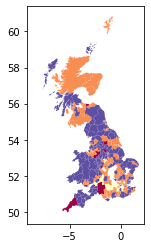

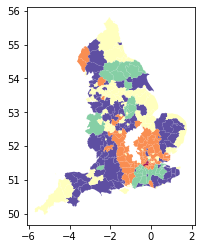

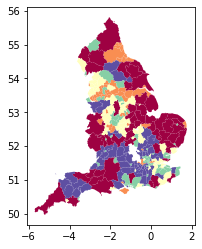

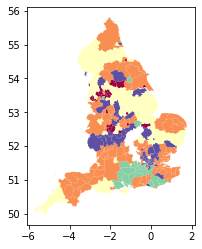

In [28]:
#OK, use same cluster numbers and see what you get.
#Note: the default colour map used by geopandas appears to be viridis.

prod_cluster = get_clusters(productivity)
prod_cluster.plot(column = "Cluster", cmap="Spectral")

pay_cluster = get_clusters(pay)
pay_cluster.plot(column = "Cluster", cmap="Spectral")

lstandards_cluster = get_clusters(lstandards)
lstandards_cluster.plot(column = "Cluster", cmap="Spectral")

skills_cluster = get_clusters(skills)
skills_cluster.plot(column = "Cluster", cmap="Spectral")


<AxesSubplot:>

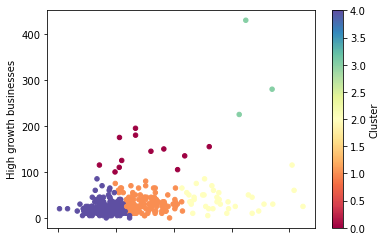

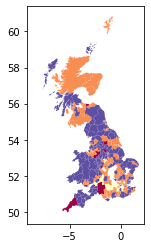

In [29]:
#This is simple as there are only two metrics classed under productivity, so the scatter should be clean.
prod_analysis = prod_cluster.merge(productivity, on="AREACD")
prod_analysis.plot.scatter(x="Gross Value Added per hour worked", 
                           y="High growth businesses",
                           c="Cluster", cmap="Spectral")
prod_cluster.plot(column = "Cluster", cmap="Spectral")

In [30]:
#This isn't the best way to do this, as cluster labelling non-determistic and meaningless.
#But for now use a dict to 'rank' the clusters in order of how well they perform.
#Simple here, split by GVA and then high growth businesses
prod_ranking={3:1, 2:2, 0:3, 1:4, 4:5}
prod_cluster['Ranked clusters']=prod_cluster['Cluster'].map(prod_ranking)

<AxesSubplot:>

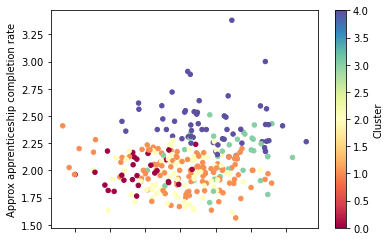

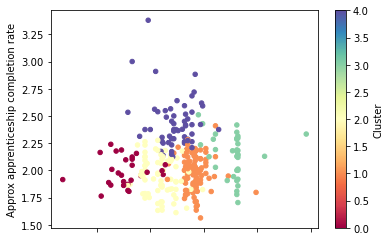

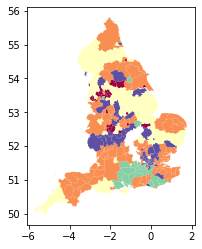

In [31]:
#More complexity here as we have 5 metrics.
skill_analysis = skills_cluster.merge(skills, on="AREACD")
skill_analysis
#This shows little
skill_analysis.plot.scatter(y="Approx apprenticeship completion rate", 
                           x="Young people achieving GCSEs (and equivalent qualifications) in English and Maths by age 19",
                           c="Cluster", cmap="Spectral")
#This shows clearer a picture of what the split looks like.
skill_analysis.plot.scatter(y="Approx apprenticeship completion rate", 
                           x="5 year olds achieving 'expected level' on communication early learning goals",
                           c="Cluster", cmap="Spectral")
skills_cluster.plot(column = "Cluster", cmap="Spectral")

In [32]:
skills_ranking={3:1, 1:2, 4:3, 2:4, 0:5}
#Middle three clusters similar here. 2nd worst marked by low GCSEs, 2nd best by high GCSEs. 
#Middle one (3rd) has higher apprenticeships.
skills_cluster['Ranked clusters']=skills_cluster['Cluster'].map(skills_ranking)

<AxesSubplot:>

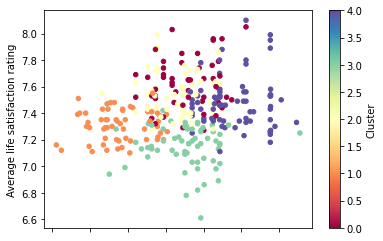

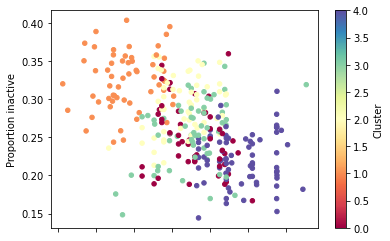

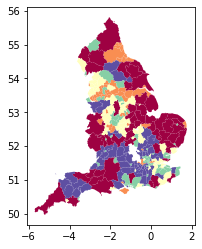

In [33]:
lstandard_analysis = lstandards_cluster.merge(lstandards, on="AREACD")
lstandard_analysis.plot.scatter(y="Average life satisfaction rating", 
                           x="Female healthy life expectancy",
                           c="Cluster", cmap="Spectral")
lstandard_analysis.plot.scatter(y="Proportion inactive", 
                           x="Female healthy life expectancy",
                           c="Cluster", cmap="Spectral")
lstandards_cluster.plot(column = "Cluster", cmap="Spectral")

In [34]:
ls_ranking={4:1, 2:2, 0:3, 3:4, 1:5}
#2nd worst cluster seperated by satisfaction from 3rd/4th. 3rd/4th split by inactivity...
lstandards_cluster['Ranked clusters']=lstandards_cluster['Cluster'].map(ls_ranking)

<AxesSubplot:>

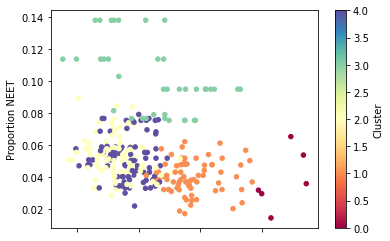

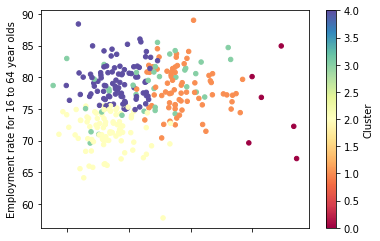

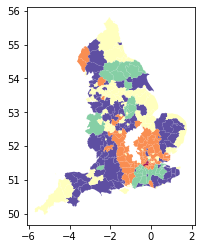

In [35]:
pay_analysis = pay_cluster.merge(pay, on="AREACD")
pay_analysis.plot.scatter(y="Proportion NEET", 
                           x="Gross median weekly pay",
                           c="Cluster", cmap="Spectral")
pay_analysis.plot.scatter(y="Employment rate for 16 to 64 year olds", 
                           x="Gross median weekly pay",
                           c="Cluster", cmap="Spectral")
pay_cluster.plot(column = "Cluster", cmap="Spectral")
#Employment rate for 16 to 64 year olds
#Proportion NEET

In [36]:
pay_ranking={0:1, 1:2, 3:3, 4:4, 2:5}
#3rd cluster spread across pay and employment, marked by high NEET.
#Lowest cluster similar in pay to 2nd; split by lower employment.
pay_cluster['Ranked clusters']=pay_cluster['Cluster'].map(pay_ranking)

In [37]:
#Combine the clusters to look for correspondance?
#Use ranked clusters here, which I have generated by eye for now.
cluster_col='Ranked clusters'
combine_clusters = prod_cluster[['AREACD',cluster_col]].merge(pay_cluster[['AREACD',cluster_col]], on='AREACD')
combine_clusters = combine_clusters.merge(lstandards_cluster[['AREACD',cluster_col]], on='AREACD')
combine_clusters = combine_clusters.merge(skills_cluster[['AREACD',cluster_col]], on='AREACD')
combine_clusters.columns = [['AREACD','prod', 'pay', 'lstandards', 'skills']]

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Ranked clusters_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


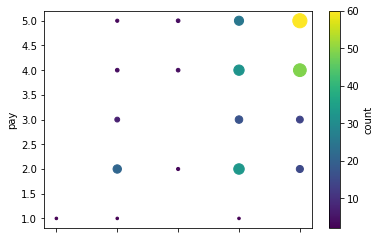

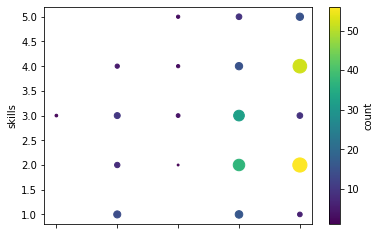

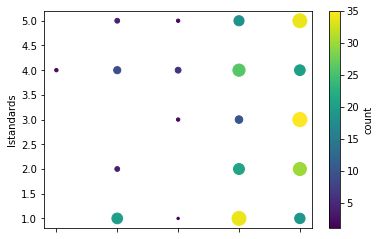

In [38]:
#Fix errors by reseting indices
combine_clusters.columns = combine_clusters.columns.get_level_values(0)

#Function to generate bubble plots -- scatters with the point size given by number obs.
def plot_bubbles(x='prod', y='pay', clusters=combine_clusters, normalise=False):
    weights=pd.DataFrame(clusters[[x,y]].value_counts())
    weights=weights.reset_index()
    weights.columns=[x,y,'count']
    if normalise:
        weights2=pd.DataFrame(clusters[[x]].value_counts())
        weights2=weights2.reset_index()
        weights2.columns=[x,'total']
        weights = weights.merge(weights2, on=x)
        weights['weight']=weights['count']/weights['total']
    else:
        weights['weight']=weights['count']
    weights['weight']/=max(weights['weight'])*0.005
    weights.plot.scatter(x, y, s='weight', c='count', cmap='viridis')

#Probably most enlightening to put the productivity on the x axis and compare to all others?
plot_bubbles('prod', 'pay')
plot_bubbles('prod', 'skills')
plot_bubbles('prod', 'lstandards')

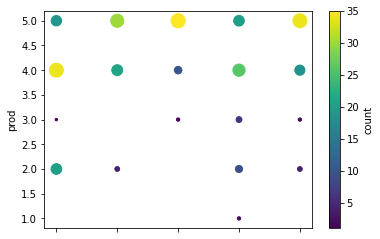

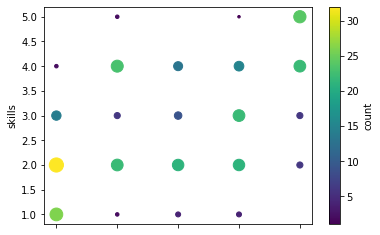

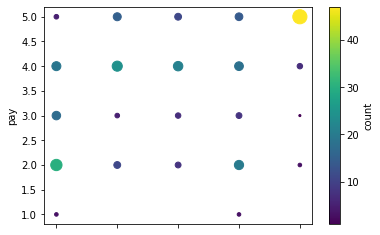

In [39]:
#Look at the living standards on the x axis.
plot_bubbles('lstandards', 'prod')
plot_bubbles('lstandards', 'skills')
plot_bubbles('lstandards', 'pay')

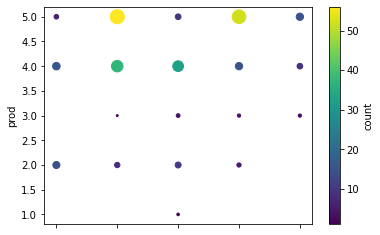

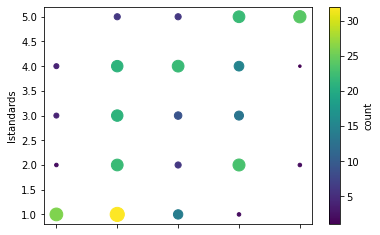

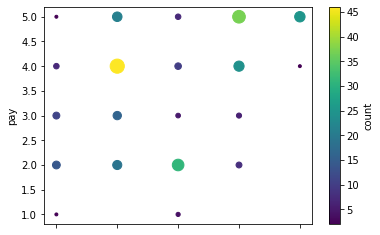

In [40]:
#Look at the skills on the x axis.
plot_bubbles('skills', 'prod')
plot_bubbles('skills', 'lstandards')
plot_bubbles('skills', 'pay')

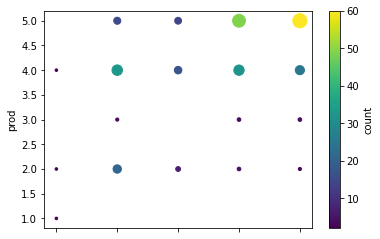

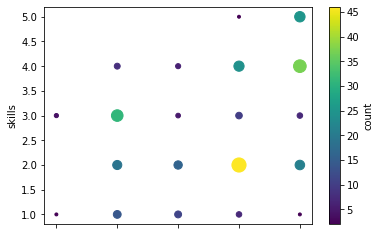

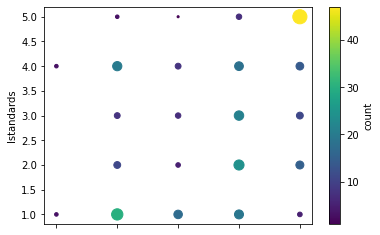

In [41]:
#Look at the pay on the x axis.
plot_bubbles('pay', 'prod')
plot_bubbles('pay', 'skills')
plot_bubbles('pay', 'lstandards')

<AxesSubplot:ylabel='Frequency'>

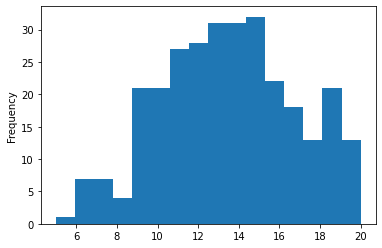

In [42]:
#For each area, make a simple score by summing the cluster ranks for a total between 4 and 20.
combine_clusters['score'] = combine_clusters['pay']+combine_clusters['prod']+combine_clusters['skills']+combine_clusters['lstandards']
combine_clusters['score'].plot.hist(bins=combine_clusters['score'].nunique())
#combine_clusters.hist()


In [43]:
#Peak at 14, but this will include a number of different ways to add up to 14.
#14 with score of 20, another 21 with 19.
#Can see these all have 5 for living standards.
combine_clusters[combine_clusters['score']==19]

,AREACD,prod,pay,lstandards,skills,score
0,E06000001,5,5,5,4,19
2,E06000003,5,5,5,4,19
5,E06000006,4,5,5,5,19
11,E06000012,5,5,5,4,19
15,E06000016,4,5,5,5,19
17,E06000018,4,5,5,5,19
19,E06000020,5,5,5,4,19
28,E06000031,4,5,5,5,19
29,E06000032,4,5,5,5,19
43,E06000046,5,5,5,4,19


In [44]:
#For a reference, here is the documnetation related to silhouettes used below.
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#

In [45]:
#OK, let's do some further work on clustering.
#Open issues -- we chose 5 clusters by hand. We also `labelled` them by visual inspection. There are gaps in the maps (believe boundary changes are the cause)
#Start with the easiest issue -- optimising N_clusters.
#Start with the prod as it's the simplest.
from sklearn.metrics import silhouette_samples, silhouette_score

kmeans = KMeans(n_clusters=5, n_init=10, max_iter=300)
np.random.seed(seed=19042022)

def get_clusters(metrics):
    no_na_metrics = metrics[metrics.notna().all(axis=1)]
    scaler = StandardScaler()
    metrics_scaled = scaler.fit_transform(no_na_metrics)
    kmeans.fit(metrics_scaled)
    clusters = pd.DataFrame(no_na_metrics.reset_index()['AREACD'])
    clusters['Cluster'] = kmeans.labels_
#    clusters = la_geo().merge(clusters, right_on = 'AREACD', left_on = 'LAD20CD', how='right')
    return(clusters)

prod_test = get_clusters(productivity)


In [46]:
prod_no_na = productivity[productivity.notna().all(axis=1)]
labels = kmeans.fit_predict(prod_no_na)
silhouette_score(prod_no_na, labels)


0.44751201543031105

2 0.8315540514246909
3 0.7876032053065674
4 0.5018602384298175
5 0.44751201543031105
6 0.44898675330962057
7 0.43443836773098143
8 0.43981218826456175
9 0.3852171340511383


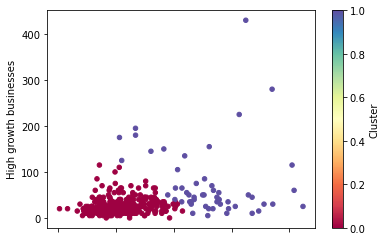

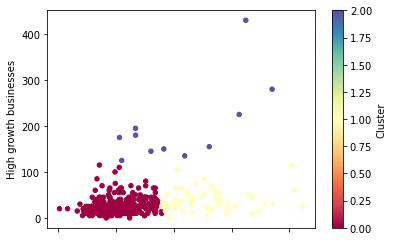

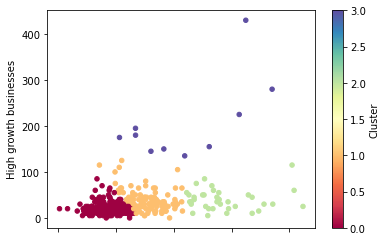

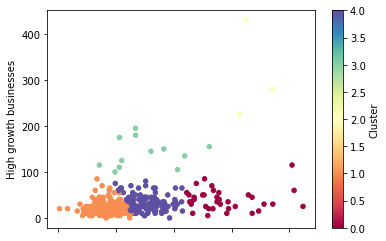

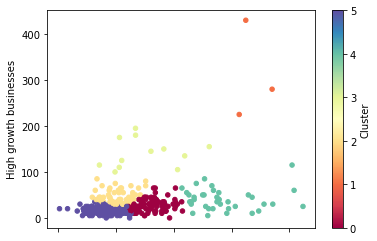

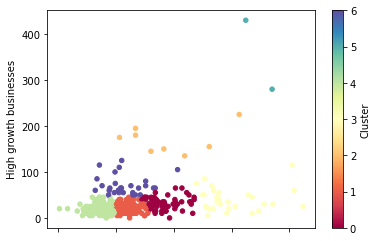

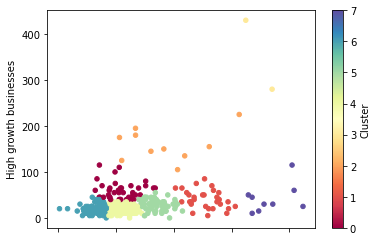

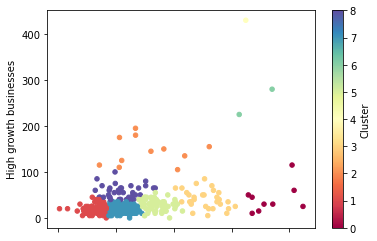

In [123]:
for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters, n_init=10, max_iter=300)
    scaler = StandardScaler()
    prod_scaled = scaler.fit_transform(prod_no_na)
    kmeans.fit(prod_scaled)
    labels = kmeans.fit_predict(prod_no_na)
    print(n_clusters, silhouette_score(prod_no_na, labels))
    labels = get_clusters(productivity)
    analysis = labels.merge(productivity, on="AREACD")
    analysis.plot.scatter(x="Gross Value Added per hour worked", 
                           y="High growth businesses",
                           c="Cluster", cmap="Spectral")



In [48]:
skill_no_na = skills[skills.notna().all(axis=1)]


for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters, n_init=10, max_iter=300)
    scaler = StandardScaler()
    skill_scaled = scaler.fit_transform(skill_no_na)
    kmeans.fit(skill_scaled)
    labels = kmeans.fit_predict(skill_no_na)
    print(n_clusters, silhouette_score(skill_no_na, labels))

2 0.36994244562538514
3 0.2860521915088306
4 0.3119761451404188
5 0.3129778241373698
6 0.3324992177218772
7 0.32002379807802234
8 0.30025535805393194
9 0.31884867845303716


In [49]:
ls_no_na = lstandards[lstandards.notna().all(axis=1)]

for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters, n_init=10, max_iter=300)
    scaler = StandardScaler()
    ls_scaled = scaler.fit_transform(ls_no_na)
    kmeans.fit(ls_scaled)
    labels = kmeans.fit_predict(ls_no_na)
    print(n_clusters, silhouette_score(ls_no_na, labels))

2 0.618555818332636
3 0.5716440221041191
4 0.5729212614991923
5 0.5251062330797621
6 0.5162886434596052
7 0.5197202385166401
8 0.5229201109507967
9 0.5271821017170168


In [50]:
pay_no_na = pay[pay.notna().all(axis=1)]

for n_clusters in range(2,10):
    kmeans = KMeans(n_clusters, n_init=10, max_iter=300)
    scaler = StandardScaler()
    pay_scaled = scaler.fit_transform(pay_no_na)
    kmeans.fit(pay_scaled)
    labels = kmeans.fit_predict(pay_no_na)
    print(n_clusters, silhouette_score(pay_no_na, labels))

2 0.6490002073833508
3 0.6091336766155455
4 0.5620489610994276
5 0.5735808551059991
6 0.5766535133603152
7 0.5724329312912687
8 0.5748473410707596
9 0.5819515789496081


Text(0.5, 1.0, 'Elbow curve')

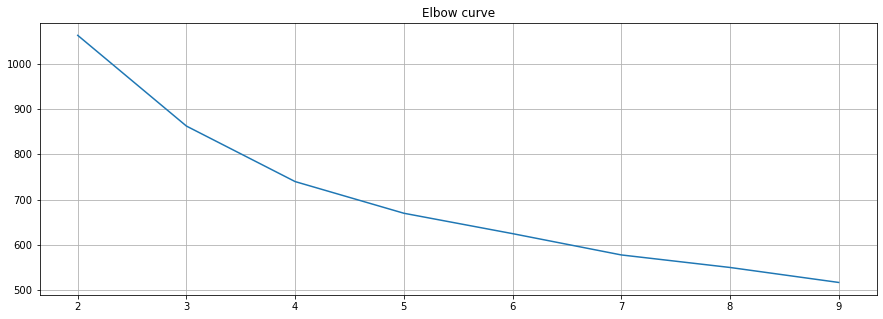

In [51]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

X = ls_scaled
distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [80]:
#Experiment with radar plots.
#Get some clusters
n_clusters=5
ls_no_na = lstandards[lstandards.notna().all(axis=1)]
kmeans = KMeans(n_clusters, n_init=10, max_iter=300)
scaler = StandardScaler()
ls_scaled = scaler.fit_transform(ls_no_na)
kmeans.fit(ls_scaled)
labels = kmeans.fit_predict(ls_scaled)


In [81]:
centres = kmeans.cluster_centers_

categories = lstandards.columns
categories = [*categories, categories[0]]



In [86]:
cluster1 = centres[0].tolist()
cluster1 = [*cluster1, cluster1[0]]

cluster2 = centres[1].tolist()
cluster2 = [*cluster2, cluster2[0]]

all_clusters=[]
for i in range(len(centres)):
    cluster_i = centres[i].tolist()
    cluster_i = [*cluster_i, cluster_i[0]]
    all_clusters.append(cluster_i)

In [87]:
all_clusters

[[0.8928873280052054,
  1.6222166500656585,
  0.058322679817220835,
  0.1415505874652957,
  -0.28445771844278106,
  0.8928873280052054],
 [-0.4722186243239486,
  -0.6179453447484992,
  -1.3778288701019643,
  -1.3752042175446177,
  1.1129632311236626,
  -0.4722186243239486],
 [0.5897974075839522,
  -0.2130958501082882,
  -0.13987959478437337,
  -0.13728381831575384,
  0.4451622626291387,
  0.5897974075839522],
 [-1.1111170007994458,
  -0.43762215915841235,
  0.05957475449612328,
  0.018053715975771524,
  -0.20864026626666915,
  -1.1111170007994458],
 [0.2570131264937747,
  -0.07832164874999752,
  1.084268731270194,
  1.0595869119874857,
  -0.8366330660316806,
  0.2570131264937747]]

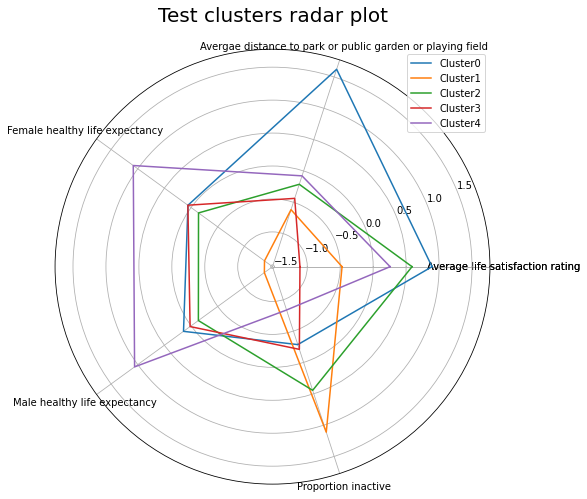

In [119]:
label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(cluster1))
plt.figure(figsize=(8, 8))
plt.subplot(polar=True)
for i in range(len(centres)):
    plt.plot(label_loc, all_clusters[i], label='Cluster'+str(i))
plt.title('Test clusters radar plot', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
plt.legend()
plt.show()